In [1]:
from heston_asian_option import HestonAsianOption
from plots import *

In [2]:
# Parameters
S0 = 100       # initial stock price
r = 0.05       # risk-free rate
T = 1.0        # time to maturity (1 year)
K = 100        # strike price 
V0 = 0.04      # initial variance (sqrt(0.04) = 0.2 initial volatility)
kappa = 2.0    # mean reversion speed
theta = 0.04   # long-term variance
xi = 0.3       # volatility of volatility
rho = -0.7     # correlation between stock and variance processes
N = 252        # number of time steps (daily)
M = 20000     # number of simulation paths

pricer = HestonAsianOption(S0, r, T, K, V0, kappa, theta, xi, rho, N, M)

Task 1: Basic Monte Carlo (Euler scheme)
Price: 5.827978
Standard Error: 0.048822
95% Confidence Interval: [5.732287, 5.923669]
Computation Time: 1.67 seconds



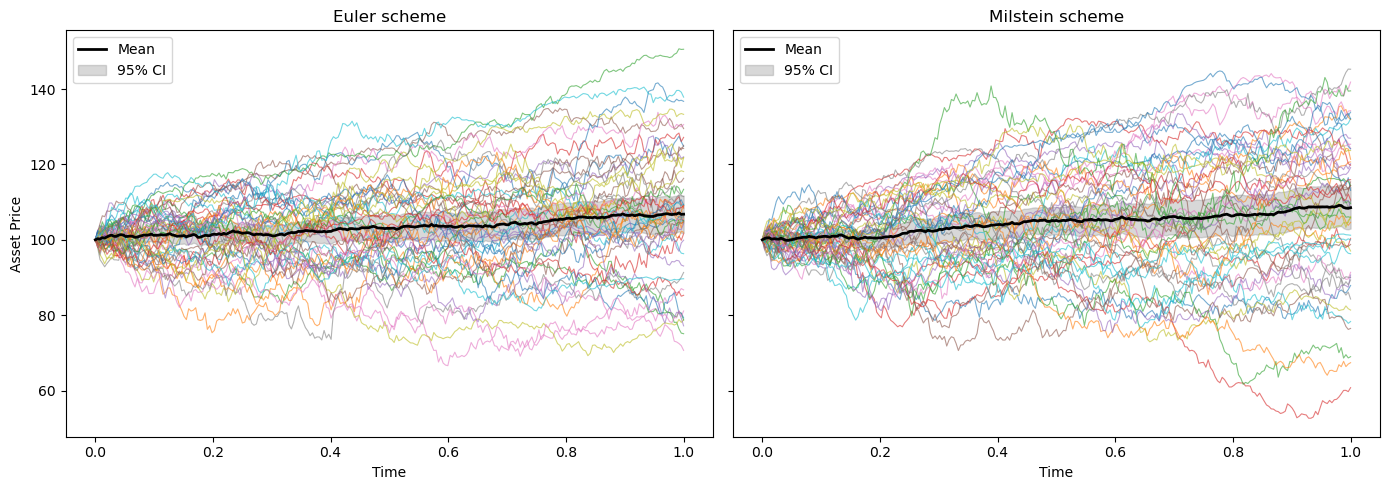

In [3]:
price, std_error, computation_time = pricer.price_arithmetic_asian_option()
print("Task 1: Basic Monte Carlo (Euler scheme)")
print(f"Price: {price:.6f}")
print(f"Standard Error: {std_error:.6f}")
print(f"95% Confidence Interval: [{price - 1.96*std_error:.6f}, {price + 1.96*std_error:.6f}]")
print(f"Computation Time: {computation_time:.2f} seconds\n")

plot_heston_paths_with_ci(pricer)

In [4]:
# Compare Euler vs Milstein schemes
schemes_comparison = pricer.compare_schemes()
print("Comparison of Discretization Schemes:")
print(f"Euler - Price: {schemes_comparison['euler']['price']:.6f}, Std Error: {schemes_comparison['euler']['std_error']:.6f}, Time: {schemes_comparison['euler']['time']:.2f}s")
print(f"Milstein - Price: {schemes_comparison['milstein']['price']:.6f}, Std Error: {schemes_comparison['milstein']['std_error']:.6f}, Time: {schemes_comparison['milstein']['time']:.2f}s\n")

Comparison of Discretization Schemes:
Euler - Price: 5.709577, Std Error: 0.048520, Time: 1.17s
Milstein - Price: 5.806814, Std Error: 0.048750, Time: 1.52s



In [5]:
# Verify with GBM (xi = 0)
heston_price, heston_std_error = pricer.verify_with_gbm()
print(f"Price: {heston_price:.6f}")
print(f"Standard Error: {heston_std_error:.6f}\n")

Price: 5.755747
Standard Error: 0.056422



In [6]:
#TODO: Verify your implementation by temporarily setting volatility-of-volatility ξ = 0 (reducing Heston to GBM) and comparing your results against known or approximated benchmarks.

## Analytical Geometric-Asian Price as Control Variate Reference

We chose as volatility of the GBM control variate the square root of the volatility of the arithmetic. The key is that once you kill off the stochastic term (ξ=0), the Heston variance:
$$
dv_t = \kappa\,(\theta - v_t)\,dt
$$

becomes a purely deterministic ODE.  Its general solution is

$$ v_t = \theta + (v_0 - \theta)e^{-\kappa t} $$

By choosing $\theta = V_0$: 

$$ v_t = V_0 + (V_0 - V_0) e^{-\kappa t} = V_0\quad\forall t $$

The whole variance path stays constant at V₀, so we set

$$ \sigma = \sqrt{v_t} = \sqrt{V_0}\, $$

and recover the standard GBM

$$ dS_t = r S_t dt + \sqrt{V_0} S_t dW_t. $$

In [7]:
# Task 2: Analytical Geometric-Asian Price as Control Variate Reference
# We use the initial volatility from Heston model
sigma = np.sqrt(V0) 
print("Task 2: Analytical Geometric-Asian Price as Control Variate")
print(f"Selected sigma for GBM: {sigma:.6f} (square root of initial variance v0)")
geo_price = pricer.analytical_geometric_asian_price(sigma)
print(f"Analytical Geometric Asian Option Price: {geo_price:.6f}\n")

Task 2: Analytical Geometric-Asian Price as Control Variate
Selected sigma for GBM: 0.200000 (square root of initial variance v0)
Analytical Geometric Asian Option Price: 6.455301



In [8]:
#TODO: Test your implementation on known scenarios to ensure accuracy.

## Implementing the Control Variate Monte Carlo

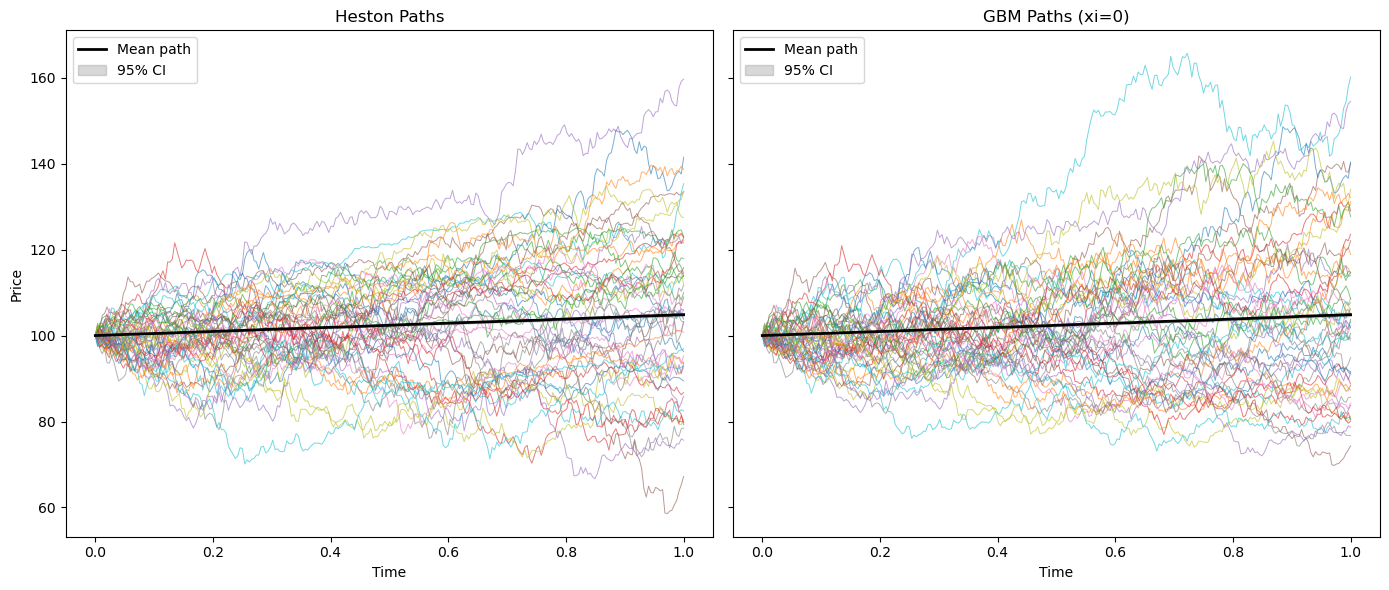

In [9]:
# Generate Heston paths
S_heston, _ = pricer.generate_paths()

# Generate parallel GBM paths using the same random numbers
S_gbm = pricer.generate_gbm_paths(sigma)

compare_path_sets(S_heston, S_gbm, T=pricer.T, title1='Heston Paths',title2='GBM Paths (xi=0)')

In [10]:
cv_results = pricer.control_variate_monte_carlo(S_heston, S_gbm, sigma)
print(f"Price without control variate: {cv_results['price_without_cv']:.6f}")
print(f"Standard Error without control variate: {cv_results['std_error_without_cv']:.6f}")
print(f"Price with control variate (c=1): {cv_results['price_with_cv']:.6f}")
print(f"Standard Error with control variate (c=1): {cv_results['std_error_with_cv']:.6f}")
print(f"Optimal Control Coefficient: {cv_results['optimal_control_coefficient']:.6f}")
print(f"Price with Optimal control variate: {cv_results['price_with_optimal_cv']:.6f}")
print(f"Standard Error with Optimal control variate: {cv_results['std_error_with_optimal_cv']:.6f}")
print(f"Variance plain: {cv_results['variance_plain']:.6f}")
print(f"Variance CV: {cv_results['variance_cv']:.6f}")
print(f"Variance Optimal CV: {cv_results['variance_optimal_cv']:.6f}")
print(f"Variance Reduction Factor (c=1): {cv_results['variance_reduction_factor_c1']:.2f}x")
print(f"Variance Reduction Factor (optimal): {cv_results['variance_reduction_factor_optimal']:.2f}x")
print(f"Computation Time: {cv_results['computation_time']:.2f} seconds\n")
    

Price without control variate: 5.751781
Standard Error without control variate: 0.048638
Price with control variate (c=1): 6.979942
Standard Error with control variate (c=1): 0.017130
Optimal Control Coefficient: 0.850779
Price with Optimal control variate: 6.840680
Standard Error with Optimal control variate: 0.016315
Variance plain: 47.312163
Variance CV: 5.868905
Variance Optimal CV: 5.323790
Variance Reduction Factor (c=1): 8.06x
Variance Reduction Factor (optimal): 8.89x
Computation Time: 0.08 seconds



## Experiments and Comparative Analysis
### Variance Reduction Efficacy

In [11]:
path_counts = np.logspace(2, 5, num=10, dtype=int)
results = pricer.experiment_varying_paths(sigma, path_counts)
print("Paths\tPrice (No CV)\tStd Err (No CV)\tPrice (CV)\tStd Err (CV)\tVR Factor")
for i in range(len(path_counts)):
    print(f"{path_counts[i]}\t{results['price_without_cv'][i]:.6f}\t"
            f"{results['std_error_without_cv'][i]:.6f}\t"
            f"{results['price_with_optimal_cv'][i]:.6f}\t"
            f"{results['std_error_with_optimal_cv'][i]:.6f}\t"
            f"{results['variance_reduction_factor_optimal'][i]:.2f}x")

Paths	Price (No CV)	Std Err (No CV)	Price (CV)	Std Err (CV)	VR Factor
100	5.238970	0.643087	6.753941	0.221010	8.47x
215	5.597588	0.446473	6.555994	0.167847	7.08x
464	5.794101	0.308105	6.975214	0.107633	8.19x
1000	5.920983	0.215540	6.827500	0.073420	8.62x
2154	6.059679	0.154015	6.839858	0.052646	8.56x
4641	5.809896	0.100656	6.793349	0.034064	8.73x
10000	5.820254	0.068450	6.828318	0.024216	7.99x
21544	5.760727	0.046891	6.804813	0.015717	8.90x
46415	5.782610	0.031953	6.837738	0.010892	8.61x
100000	5.747759	0.021689	6.803920	0.007439	8.50x


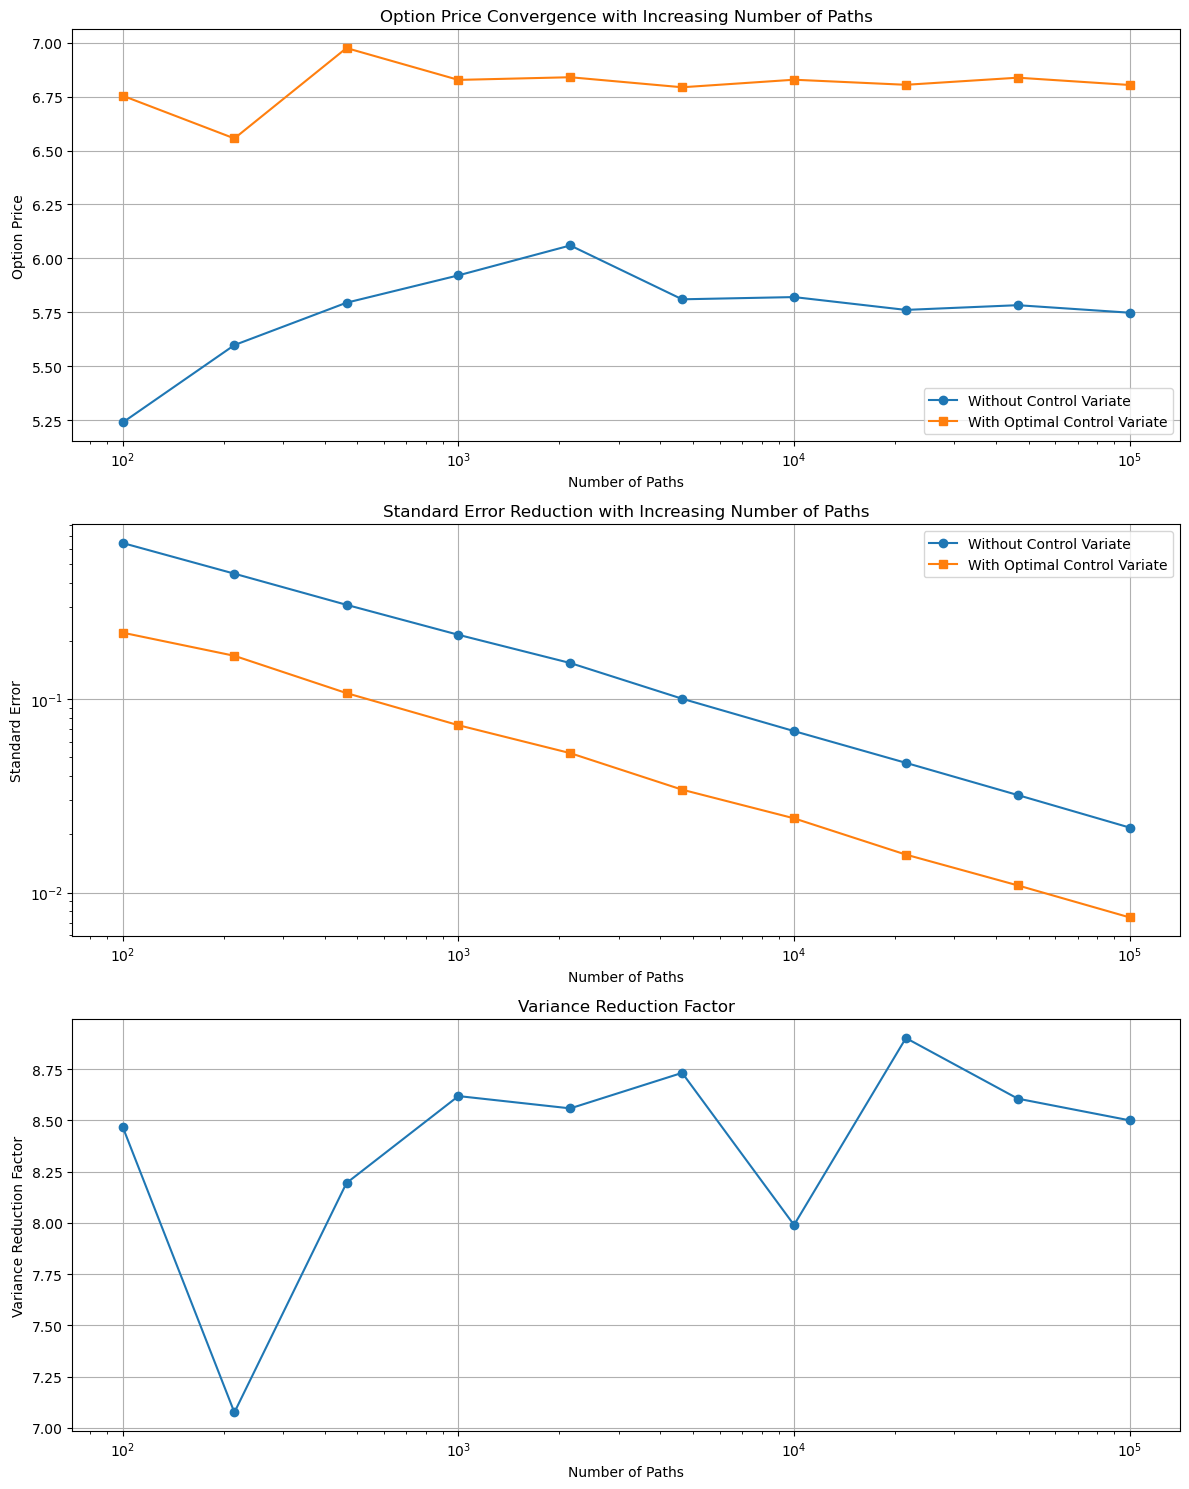

In [12]:
plot_variance_reduction_efficacy(results)

### Impact of Varying Heston Parameters

In [ ]:
rho_values=np.linspace(-0.99, 0.99, 20)
xi_values=np.linspace(0.1, 5, 20)
K_values=np.linspace(80, 120, 20)
v0_values=np.linspace(0.1, 5, 20)
plot_optimal_control_coefficient(rho_values, xi_values, K_values, v0_values)

TypeError: plot_optimal_control_coefficient() takes from 0 to 4 positional arguments but 5 were given

### Impact of varying frequencies

In [ ]:
frequencies = [12, 52, 252]  # monthly, weekly, daily, hourly
frequency_results = pricer.experiment_averaging_frequency(sigma, frequencies)
print("Task 4c: Impact of Averaging Frequency")
print("Frequency\tPrice (No CV)\tStd Err (No CV)\tPrice (CV)\tStd Err (CV)\tVR Factor")
for i in range(len(frequencies)):
    print(f"{frequencies[i]}\t{frequency_results['price_without_cv'][i]:.6f}\t"
            f"{frequency_results['std_error_without_cv'][i]:.6f}\t"
            f"{frequency_results['price_with_cv'][i]:.6f}\t"
            f"{frequency_results['std_error_with_cv'][i]:.6f}\t"
            f"{frequency_results['variance_reduction_factor'][i]:.2f}x")
    
# Optimal c* already found, maybe move here

Task 4c: Impact of Averaging Frequency
Frequency	Price (No CV)	Std Err (No CV)	Price (CV)	Std Err (CV)	VR Factor
12	6.078041	0.051982	6.803581	0.019556	7.07x
52	5.798766	0.048825	6.787310	0.017315	7.95x
252	5.798319	0.048545	6.824334	0.016534	8.62x
6048	5.736055	0.048109	6.829308	0.016184	8.84x


In [ ]:
#TODO: Try wwith different control variates